F74091132_GAI_Project4

Step 1: Deep Image Prior (DIP) Model

Step 2: Denoising Diffusion Probabilistic Model (DDPM) with DIP Prior

Step 3: Evaluation

1.Using DDPM alone

Files already downloaded and verified


100%|██████████| 782/782 [00:51<00:00, 15.10it/s]


Epoch [1/10], Loss: 0.005624772474357901


100%|██████████| 782/782 [00:52<00:00, 15.01it/s]


Epoch [2/10], Loss: 0.0006893004995541196


100%|██████████| 782/782 [00:51<00:00, 15.07it/s]


Epoch [3/10], Loss: 0.00043455571067914584


100%|██████████| 782/782 [00:52<00:00, 14.91it/s]


Epoch [4/10], Loss: 0.00035115066992641187


100%|██████████| 782/782 [00:51<00:00, 15.04it/s]


Epoch [5/10], Loss: 0.0002914171657877301


100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


Epoch [6/10], Loss: 0.00027436351923536555


100%|██████████| 782/782 [00:52<00:00, 14.85it/s]


Epoch [7/10], Loss: 0.0002479318849988753


100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


Epoch [8/10], Loss: 0.00024114218862697362


100%|██████████| 782/782 [00:52<00:00, 15.00it/s]


Epoch [9/10], Loss: 0.00023820326244851196


100%|██████████| 782/782 [00:52<00:00, 14.92it/s]


Epoch [10/10], Loss: 0.0002119315709291293


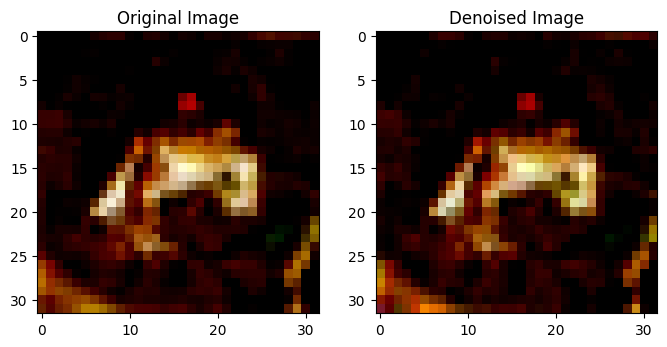

PSNR: 29.364598170803415
SSIM: 0.821960573396759


<ipython-input-17-eb010cbb118e>:113: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [17]:
# Using DDPM alone
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm

# Step 1: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 2: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 3: Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_blocks = 10
channels = 3  # For RGB images
noise_schedule = [0.01 * (i / 1000) for i in range(1000)]  # Example noise schedule
model = DDPM(num_blocks, channels, noise_schedule).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, t=torch.randint(0, len(noise_schedule), (1,)).item())
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 5: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        if len(image.shape) == 3:  # Single image
            x = image.unsqueeze(0).to(device)
            for t in range(num_steps):
                x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
            return x.cpu().squeeze(0)
        elif len(image.shape) == 4:  # Batch of images
            denoised_images = []
            for i in range(image.shape[0]):
                x = image[i].unsqueeze(0).to(device)
                for t in range(num_steps):
                    x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
                denoised_images.append(x.cpu().squeeze(0))
            return torch.stack(denoised_images)


# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

2.Using DDPM + DIP

Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 49.94it/s]


DIP Epoch [1/10], Loss: 0.03503537988718933


100%|██████████| 782/782 [00:15<00:00, 50.57it/s]


DIP Epoch [2/10], Loss: 0.005971370113190606


100%|██████████| 782/782 [00:15<00:00, 50.99it/s]


DIP Epoch [3/10], Loss: 0.0013543083989734303


100%|██████████| 782/782 [00:15<00:00, 51.21it/s]


DIP Epoch [4/10], Loss: 0.0005537276696267864


100%|██████████| 782/782 [00:15<00:00, 51.07it/s]


DIP Epoch [5/10], Loss: 0.00030281096433728216


100%|██████████| 782/782 [00:15<00:00, 51.68it/s]


DIP Epoch [6/10], Loss: 0.0001795427342120539


100%|██████████| 782/782 [00:15<00:00, 50.89it/s]


DIP Epoch [7/10], Loss: 0.0001086464801905504


100%|██████████| 782/782 [00:15<00:00, 51.41it/s]


DIP Epoch [8/10], Loss: 6.940358343156491e-05


100%|██████████| 782/782 [00:15<00:00, 51.29it/s]


DIP Epoch [9/10], Loss: 4.8628849827948257e-05


100%|██████████| 782/782 [00:15<00:00, 51.16it/s]


DIP Epoch [10/10], Loss: 3.640971172361976e-05


100%|██████████| 782/782 [00:53<00:00, 14.75it/s]


DDPM Epoch [1/10], Loss: 0.008249366287867922


100%|██████████| 782/782 [00:53<00:00, 14.63it/s]


DDPM Epoch [2/10], Loss: 0.0008876090100400693


100%|██████████| 782/782 [00:52<00:00, 14.90it/s]


DDPM Epoch [3/10], Loss: 0.0005441964810329747


100%|██████████| 782/782 [00:52<00:00, 15.00it/s]


DDPM Epoch [4/10], Loss: 0.0004264237553718925


100%|██████████| 782/782 [00:51<00:00, 15.08it/s]


DDPM Epoch [5/10], Loss: 0.00035701684974459396


100%|██████████| 782/782 [00:52<00:00, 14.94it/s]


DDPM Epoch [6/10], Loss: 0.00033497811664974996


100%|██████████| 782/782 [00:52<00:00, 14.98it/s]


DDPM Epoch [7/10], Loss: 0.00032420140219783253


100%|██████████| 782/782 [00:52<00:00, 14.77it/s]


DDPM Epoch [8/10], Loss: 0.00029931001567757865


100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


DDPM Epoch [9/10], Loss: 0.00027951569411569557


100%|██████████| 782/782 [00:52<00:00, 14.77it/s]


DDPM Epoch [10/10], Loss: 0.0002892012752084475


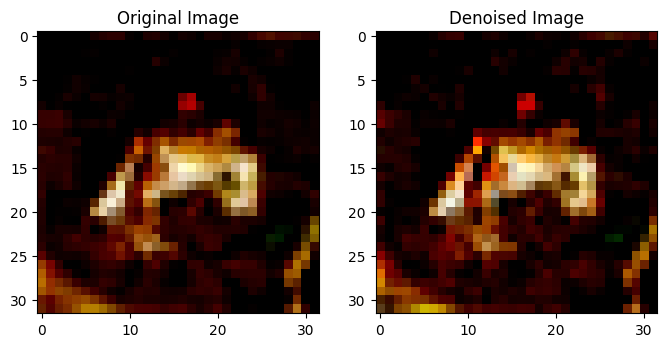

PSNR: 29.704530347304974
SSIM: 0.9425709843635559


<ipython-input-13-861ada72d283>:143: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [13]:
# Using DDPM + DIP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
noise_schedule = [0.01 * (i / 1000) for i in range(1000)]  # Example noise schedule
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

DIP + DDPM, Fine-tuning Experiments

(1)Exp1-1: DDPM's lr=0.01

Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 51.20it/s]


DIP Epoch [1/10], Loss: 0.03856143668589308


100%|██████████| 782/782 [00:15<00:00, 50.85it/s]


DIP Epoch [2/10], Loss: 0.009587470784454662


100%|██████████| 782/782 [00:15<00:00, 51.14it/s]


DIP Epoch [3/10], Loss: 0.006341464243486257


100%|██████████| 782/782 [00:15<00:00, 51.34it/s]


DIP Epoch [4/10], Loss: 0.004851650262949393


100%|██████████| 782/782 [00:15<00:00, 51.38it/s]


DIP Epoch [5/10], Loss: 0.004340144931255361


100%|██████████| 782/782 [00:15<00:00, 51.00it/s]


DIP Epoch [6/10], Loss: 0.004133613425535638


100%|██████████| 782/782 [00:15<00:00, 51.16it/s]


DIP Epoch [7/10], Loss: 0.0040345588787411195


100%|██████████| 782/782 [00:15<00:00, 52.00it/s]


DIP Epoch [8/10], Loss: 0.00398807764848899


100%|██████████| 782/782 [00:15<00:00, 51.64it/s]


DIP Epoch [9/10], Loss: 0.003951997310399552


100%|██████████| 782/782 [00:15<00:00, 51.59it/s]


DIP Epoch [10/10], Loss: 0.003933402958124771


100%|██████████| 782/782 [00:51<00:00, 15.08it/s]


DDPM Epoch [1/10], Loss: 0.005326916957321718


100%|██████████| 782/782 [00:51<00:00, 15.11it/s]


DDPM Epoch [2/10], Loss: 0.0040157547216419405


100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


DDPM Epoch [3/10], Loss: 0.003945877625490241


100%|██████████| 782/782 [00:52<00:00, 15.01it/s]


DDPM Epoch [4/10], Loss: 0.0037740369629867547


100%|██████████| 782/782 [00:52<00:00, 14.84it/s]


DDPM Epoch [5/10], Loss: 0.0038189393737058028


100%|██████████| 782/782 [00:52<00:00, 14.95it/s]


DDPM Epoch [6/10], Loss: 0.003805826974870718


100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


DDPM Epoch [7/10], Loss: 0.0037938869014010786


100%|██████████| 782/782 [00:52<00:00, 14.84it/s]


DDPM Epoch [8/10], Loss: 0.003818812113448196


100%|██████████| 782/782 [00:53<00:00, 14.51it/s]


DDPM Epoch [9/10], Loss: 0.003814045133490754


100%|██████████| 782/782 [00:53<00:00, 14.62it/s]


DDPM Epoch [10/10], Loss: 0.004008512848111636


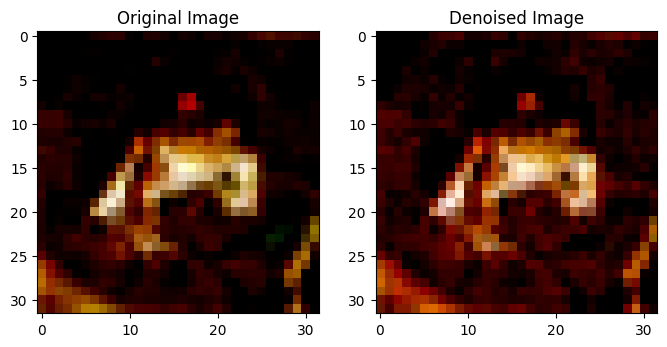

PSNR: 28.205482938237747
SSIM: 0.8151518702507019


<ipython-input-4-3a1bd289fa5b>:143: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
noise_schedule = [0.01 * (i / 1000) for i in range(1000)]  # Example noise schedule
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.01)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

(2)Exp1-2: Both DIP and DDPM -> lr=0.01

Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 51.17it/s]


DIP Epoch [1/10], Loss: 0.010833212427254242


100%|██████████| 782/782 [00:15<00:00, 50.92it/s]


DIP Epoch [2/10], Loss: 0.004191741366665858


100%|██████████| 782/782 [00:15<00:00, 50.97it/s]


DIP Epoch [3/10], Loss: 0.004039593850788863


100%|██████████| 782/782 [00:15<00:00, 51.09it/s]


DIP Epoch [4/10], Loss: 0.0040357173776285026


100%|██████████| 782/782 [00:15<00:00, 50.56it/s]


DIP Epoch [5/10], Loss: 0.00403301366854964


100%|██████████| 782/782 [00:15<00:00, 51.10it/s]


DIP Epoch [6/10], Loss: 0.004001858744971559


100%|██████████| 782/782 [00:15<00:00, 51.34it/s]


DIP Epoch [7/10], Loss: 0.003973958050043744


100%|██████████| 782/782 [00:15<00:00, 51.25it/s]


DIP Epoch [8/10], Loss: 0.0039807938441546046


100%|██████████| 782/782 [00:15<00:00, 51.12it/s]


DIP Epoch [9/10], Loss: 0.003995823814138256


100%|██████████| 782/782 [00:15<00:00, 51.64it/s]


DIP Epoch [10/10], Loss: 0.004006820943449502


100%|██████████| 782/782 [00:53<00:00, 14.51it/s]


DDPM Epoch [1/10], Loss: 0.005956944163955386


100%|██████████| 782/782 [00:53<00:00, 14.68it/s]


DDPM Epoch [2/10], Loss: 0.0038072485137311623


100%|██████████| 782/782 [00:53<00:00, 14.53it/s]


DDPM Epoch [3/10], Loss: 0.0037052962432384414


100%|██████████| 782/782 [00:53<00:00, 14.64it/s]


DDPM Epoch [4/10], Loss: 0.0036557061497069646


100%|██████████| 782/782 [00:53<00:00, 14.50it/s]


DDPM Epoch [5/10], Loss: 0.0036449150577999765


100%|██████████| 782/782 [00:53<00:00, 14.50it/s]


DDPM Epoch [6/10], Loss: 0.0036782472940159443


100%|██████████| 782/782 [00:53<00:00, 14.51it/s]


DDPM Epoch [7/10], Loss: 0.0036424843033494624


100%|██████████| 782/782 [00:53<00:00, 14.72it/s]


DDPM Epoch [8/10], Loss: 0.0038023187443637827


100%|██████████| 782/782 [00:53<00:00, 14.69it/s]


DDPM Epoch [9/10], Loss: 0.0037465723394594914


100%|██████████| 782/782 [00:53<00:00, 14.58it/s]


DDPM Epoch [10/10], Loss: 0.0037246099711917436


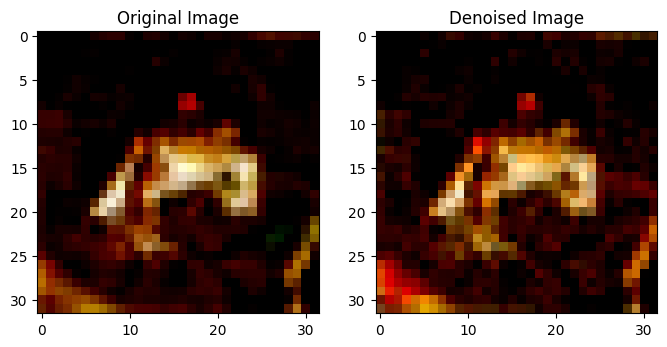

PSNR: 26.85258582596889
SSIM: 0.8381494879722595


<ipython-input-5-536a4f8077e7>:143: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.01)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
noise_schedule = [0.01 * (i / 1000) for i in range(1000)]  # Example noise schedule
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.01)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

(3)Exp2-1: Change noise_schedule to Exponential Decay Schedule: noise_schedule = [0.1 * (0.95 ** i) for i in range(1000)]

Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 51.21it/s]


DIP Epoch [1/10], Loss: 0.03206059810779322


100%|██████████| 782/782 [00:15<00:00, 51.02it/s]


DIP Epoch [2/10], Loss: 0.008551322221470153


100%|██████████| 782/782 [00:15<00:00, 51.69it/s]


DIP Epoch [3/10], Loss: 0.005499111770121071


100%|██████████| 782/782 [00:15<00:00, 51.78it/s]


DIP Epoch [4/10], Loss: 0.004517682257842015


100%|██████████| 782/782 [00:15<00:00, 51.90it/s]


DIP Epoch [5/10], Loss: 0.004199829864520532


100%|██████████| 782/782 [00:15<00:00, 51.24it/s]


DIP Epoch [6/10], Loss: 0.004074294586330081


100%|██████████| 782/782 [00:15<00:00, 51.18it/s]


DIP Epoch [7/10], Loss: 0.004007193436453124


100%|██████████| 782/782 [00:15<00:00, 50.88it/s]


DIP Epoch [8/10], Loss: 0.003972290926213946


100%|██████████| 782/782 [00:15<00:00, 51.64it/s]


DIP Epoch [9/10], Loss: 0.003953633870443572


100%|██████████| 782/782 [00:15<00:00, 51.57it/s]


DIP Epoch [10/10], Loss: 0.003928305481321147


100%|██████████| 782/782 [00:53<00:00, 14.55it/s]


DDPM Epoch [1/10], Loss: 0.012162493065456905


100%|██████████| 782/782 [00:54<00:00, 14.39it/s]


DDPM Epoch [2/10], Loss: 0.0051190330437920475


100%|██████████| 782/782 [00:54<00:00, 14.29it/s]


DDPM Epoch [3/10], Loss: 0.00453490221157165


100%|██████████| 782/782 [00:53<00:00, 14.52it/s]


DDPM Epoch [4/10], Loss: 0.004368908279944602


100%|██████████| 782/782 [00:53<00:00, 14.48it/s]


DDPM Epoch [5/10], Loss: 0.004216702446541594


100%|██████████| 782/782 [00:54<00:00, 14.35it/s]


DDPM Epoch [6/10], Loss: 0.004527300678710441


100%|██████████| 782/782 [00:54<00:00, 14.45it/s]


DDPM Epoch [7/10], Loss: 0.004077225765141914


100%|██████████| 782/782 [00:54<00:00, 14.25it/s]


DDPM Epoch [8/10], Loss: 0.003798782748058248


100%|██████████| 782/782 [00:54<00:00, 14.47it/s]


DDPM Epoch [9/10], Loss: 0.004136544890175371


100%|██████████| 782/782 [00:54<00:00, 14.42it/s]


DDPM Epoch [10/10], Loss: 0.0039421139778319245


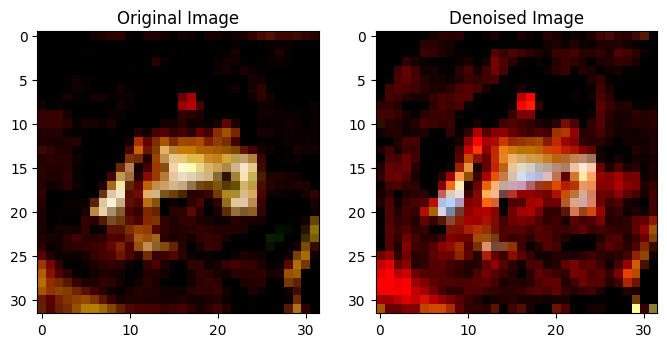

PSNR: 22.180261632492275
SSIM: 0.6513616442680359


<ipython-input-7-957839d368a1>:144: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
### Exp2 here
noise_schedule = [0.1 * (0.95 ** i) for i in range(1000)]
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

(4)Exp2-2: Change noise_schedule to Cosine Schedule
: noise_schedule = [0.5 * (1 + np.cos((i / 1000) * np.pi)) for i in range(1000)]

Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 50.92it/s]


DIP Epoch [1/10], Loss: 0.033878835768479366


100%|██████████| 782/782 [00:15<00:00, 51.27it/s]


DIP Epoch [2/10], Loss: 0.006106745137575814


100%|██████████| 782/782 [00:15<00:00, 50.85it/s]


DIP Epoch [3/10], Loss: 0.0018038513272723225


100%|██████████| 782/782 [00:15<00:00, 51.35it/s]


DIP Epoch [4/10], Loss: 0.000668678915968029


100%|██████████| 782/782 [00:15<00:00, 50.51it/s]


DIP Epoch [5/10], Loss: 0.00039259065873027704


100%|██████████| 782/782 [00:15<00:00, 50.52it/s]


DIP Epoch [6/10], Loss: 0.00026731735839985747


100%|██████████| 782/782 [00:15<00:00, 50.86it/s]


DIP Epoch [7/10], Loss: 0.00018795711184328403


100%|██████████| 782/782 [00:15<00:00, 50.86it/s]


DIP Epoch [8/10], Loss: 0.00013270044892914998


100%|██████████| 782/782 [00:15<00:00, 51.28it/s]


DIP Epoch [9/10], Loss: 9.630218536425244e-05


100%|██████████| 782/782 [00:15<00:00, 51.02it/s]


DIP Epoch [10/10], Loss: 7.466555074447721e-05


100%|██████████| 782/782 [00:52<00:00, 14.80it/s]


DDPM Epoch [1/10], Loss: 1.0906921080063523


100%|██████████| 782/782 [00:53<00:00, 14.63it/s]


DDPM Epoch [2/10], Loss: 0.5466391266992939


100%|██████████| 782/782 [00:51<00:00, 15.05it/s]


DDPM Epoch [3/10], Loss: 0.47254680933387916


100%|██████████| 782/782 [00:52<00:00, 14.79it/s]


DDPM Epoch [4/10], Loss: 0.46062521571222015


100%|██████████| 782/782 [00:52<00:00, 14.84it/s]


DDPM Epoch [5/10], Loss: 0.44956548684669656


100%|██████████| 782/782 [00:52<00:00, 14.92it/s]


DDPM Epoch [6/10], Loss: 0.446667695565678


100%|██████████| 782/782 [00:53<00:00, 14.72it/s]


DDPM Epoch [7/10], Loss: 0.4128772611134326


100%|██████████| 782/782 [00:52<00:00, 14.80it/s]


DDPM Epoch [8/10], Loss: 0.4322826001016647


100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


DDPM Epoch [9/10], Loss: 0.42565158510799794


100%|██████████| 782/782 [00:52<00:00, 14.78it/s]


DDPM Epoch [10/10], Loss: 0.39131793991336244


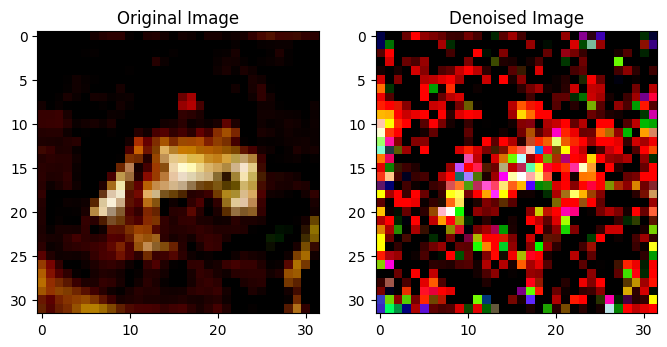

PSNR: 8.587089058015046
SSIM: 0.09730891138315201


<ipython-input-9-4aa8036cc69c>:145: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
### Exp2 here
noise_schedule = [0.5 * (1 + np.cos((i / 1000) * np.pi)) for i in range(1000)]
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

(5)Exp2-3: Change noise_schedule to Polynomial Schedule:  noise_schedule = [0.5 * (1 + np.cos((i / 1000) * np.pi)) for i in range(1000)]



Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 51.23it/s]


DIP Epoch [1/10], Loss: 0.05411909211931936


100%|██████████| 782/782 [00:15<00:00, 50.96it/s]


DIP Epoch [2/10], Loss: 0.009377913261928102


100%|██████████| 782/782 [00:15<00:00, 50.70it/s]


DIP Epoch [3/10], Loss: 0.0031017846020850856


100%|██████████| 782/782 [00:15<00:00, 50.83it/s]


DIP Epoch [4/10], Loss: 0.0010263458585224885


100%|██████████| 782/782 [00:15<00:00, 50.77it/s]


DIP Epoch [5/10], Loss: 0.0006071272847802996


100%|██████████| 782/782 [00:15<00:00, 50.99it/s]


DIP Epoch [6/10], Loss: 0.0003978420229120444


100%|██████████| 782/782 [00:15<00:00, 50.97it/s]


DIP Epoch [7/10], Loss: 0.0002500276323585042


100%|██████████| 782/782 [00:15<00:00, 51.51it/s]


DIP Epoch [8/10], Loss: 0.0001502132607901426


100%|██████████| 782/782 [00:15<00:00, 51.59it/s]


DIP Epoch [9/10], Loss: 9.752761409699838e-05


100%|██████████| 782/782 [00:15<00:00, 51.53it/s]


DIP Epoch [10/10], Loss: 6.926773856744578e-05


100%|██████████| 782/782 [00:53<00:00, 14.74it/s]


DDPM Epoch [1/10], Loss: 0.030461368903391482


100%|██████████| 782/782 [00:53<00:00, 14.74it/s]


DDPM Epoch [2/10], Loss: 0.014264933969331262


100%|██████████| 782/782 [00:53<00:00, 14.74it/s]


DDPM Epoch [3/10], Loss: 0.012016163210567954


100%|██████████| 782/782 [00:53<00:00, 14.69it/s]


DDPM Epoch [4/10], Loss: 0.010775345072889811


100%|██████████| 782/782 [00:52<00:00, 14.95it/s]


DDPM Epoch [5/10], Loss: 0.00966931338963287


100%|██████████| 782/782 [00:52<00:00, 14.85it/s]


DDPM Epoch [6/10], Loss: 0.00961440330599923


100%|██████████| 782/782 [00:52<00:00, 14.91it/s]


DDPM Epoch [7/10], Loss: 0.009013918823624492


100%|██████████| 782/782 [00:52<00:00, 15.03it/s]


DDPM Epoch [8/10], Loss: 0.008543643986691942


100%|██████████| 782/782 [00:52<00:00, 14.85it/s]


DDPM Epoch [9/10], Loss: 0.008059197822865575


100%|██████████| 782/782 [00:53<00:00, 14.64it/s]


DDPM Epoch [10/10], Loss: 0.008128600468968643


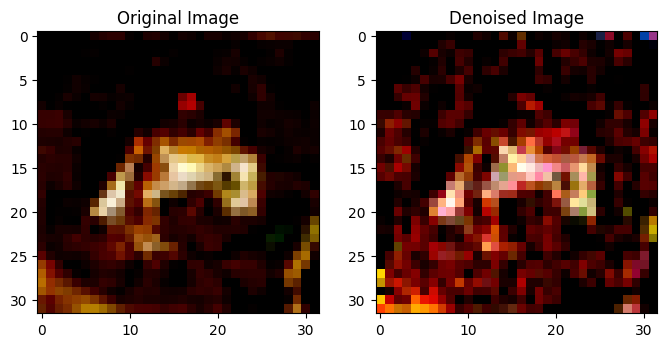

PSNR: 18.575871208247335
SSIM: 0.531550407409668


<ipython-input-10-6701764373cc>:145: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
### Exp2 here
noise_schedule = [0.1 * (1 - (i / 1000) ** 2) for i in range(1000)]
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

(6)Exp3: Adjust batch size to 128

Files already downloaded and verified


100%|██████████| 391/391 [00:13<00:00, 29.68it/s]


DIP Epoch [1/10], Loss: 0.055453838294614914


100%|██████████| 391/391 [00:13<00:00, 29.78it/s]


DIP Epoch [2/10], Loss: 0.015865247120218508


100%|██████████| 391/391 [00:13<00:00, 29.95it/s]


DIP Epoch [3/10], Loss: 0.00908755980041402


100%|██████████| 391/391 [00:13<00:00, 29.84it/s]


DIP Epoch [4/10], Loss: 0.00682242918888207


100%|██████████| 391/391 [00:13<00:00, 30.00it/s]


DIP Epoch [5/10], Loss: 0.005675839284634994


100%|██████████| 391/391 [00:13<00:00, 29.53it/s]


DIP Epoch [6/10], Loss: 0.004949950522569287


100%|██████████| 391/391 [00:13<00:00, 29.39it/s]


DIP Epoch [7/10], Loss: 0.00454921255547963


100%|██████████| 391/391 [00:13<00:00, 29.74it/s]


DIP Epoch [8/10], Loss: 0.004321731810989168


100%|██████████| 391/391 [00:13<00:00, 29.59it/s]


DIP Epoch [9/10], Loss: 0.004177279015907737


100%|██████████| 391/391 [00:13<00:00, 29.29it/s]


DIP Epoch [10/10], Loss: 0.004092127208590812


100%|██████████| 391/391 [00:40<00:00,  9.60it/s]


DDPM Epoch [1/10], Loss: 0.01265446000013148


100%|██████████| 391/391 [00:40<00:00,  9.64it/s]


DDPM Epoch [2/10], Loss: 0.0047922215908003584


100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


DDPM Epoch [3/10], Loss: 0.004278873565042263


100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


DDPM Epoch [4/10], Loss: 0.004093130110808269


100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


DDPM Epoch [5/10], Loss: 0.003989414665657465


100%|██████████| 391/391 [00:40<00:00,  9.72it/s]


DDPM Epoch [6/10], Loss: 0.003871389240731516


100%|██████████| 391/391 [00:40<00:00,  9.70it/s]


DDPM Epoch [7/10], Loss: 0.003805848101125387


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


DDPM Epoch [8/10], Loss: 0.0037642156334874955


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


DDPM Epoch [9/10], Loss: 0.0037219153402749533


100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


DDPM Epoch [10/10], Loss: 0.0036740284407144543


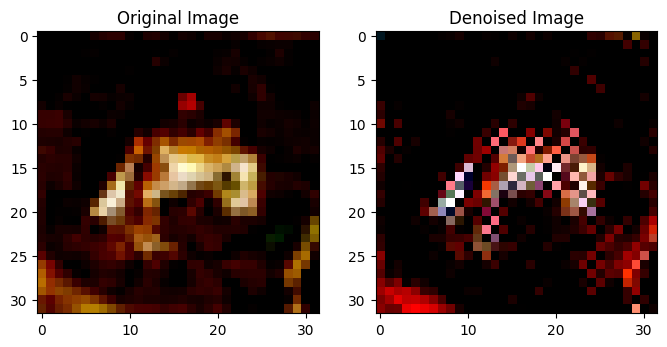

PSNR: 17.796502448729665
SSIM: 0.42997655272483826


<ipython-input-11-6cc9393b0115>:144: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Exp3 here
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 10
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
noise_schedule = [0.01 * (i / 1000) for i in range(1000)]  # Example noise schedule
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 10
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

(7)Exp4: Adjust epochs to 20 for both DIP and DDPM

Files already downloaded and verified


100%|██████████| 782/782 [00:15<00:00, 51.41it/s]


DIP Epoch [1/20], Loss: 0.05332531060194573


100%|██████████| 782/782 [00:15<00:00, 51.57it/s]


DIP Epoch [2/20], Loss: 0.006013610349644137


100%|██████████| 782/782 [00:15<00:00, 51.17it/s]


DIP Epoch [3/20], Loss: 0.0030302134638889202


100%|██████████| 782/782 [00:15<00:00, 51.06it/s]


DIP Epoch [4/20], Loss: 0.001054092844733206


100%|██████████| 782/782 [00:15<00:00, 51.23it/s]


DIP Epoch [5/20], Loss: 0.0005368172516026582


100%|██████████| 782/782 [00:15<00:00, 51.67it/s]


DIP Epoch [6/20], Loss: 0.00032757227976352115


100%|██████████| 782/782 [00:15<00:00, 51.64it/s]


DIP Epoch [7/20], Loss: 0.0002083385513597162


100%|██████████| 782/782 [00:15<00:00, 51.81it/s]


DIP Epoch [8/20], Loss: 0.00013230946040405627


100%|██████████| 782/782 [00:15<00:00, 51.33it/s]


DIP Epoch [9/20], Loss: 8.293084706065318e-05


100%|██████████| 782/782 [00:15<00:00, 50.33it/s]


DIP Epoch [10/20], Loss: 5.47888773682011e-05


100%|██████████| 782/782 [00:15<00:00, 51.53it/s]


DIP Epoch [11/20], Loss: 3.942148114940973e-05


100%|██████████| 782/782 [00:15<00:00, 51.50it/s]


DIP Epoch [12/20], Loss: 3.0692873752343674e-05


100%|██████████| 782/782 [00:15<00:00, 51.37it/s]


DIP Epoch [13/20], Loss: 2.4835197807318243e-05


100%|██████████| 782/782 [00:15<00:00, 51.75it/s]


DIP Epoch [14/20], Loss: 2.061327342600118e-05


100%|██████████| 782/782 [00:15<00:00, 51.83it/s]


DIP Epoch [15/20], Loss: 1.692306959088353e-05


100%|██████████| 782/782 [00:15<00:00, 51.32it/s]


DIP Epoch [16/20], Loss: 1.4582923801830838e-05


100%|██████████| 782/782 [00:15<00:00, 51.96it/s]


DIP Epoch [17/20], Loss: 1.2157790186165003e-05


100%|██████████| 782/782 [00:15<00:00, 50.98it/s]


DIP Epoch [18/20], Loss: 1.0670691175888964e-05


100%|██████████| 782/782 [00:15<00:00, 51.28it/s]


DIP Epoch [19/20], Loss: 9.326822827149307e-06


100%|██████████| 782/782 [00:15<00:00, 50.75it/s]


DIP Epoch [20/20], Loss: 8.36222059491137e-06


100%|██████████| 782/782 [00:53<00:00, 14.58it/s]


DDPM Epoch [1/20], Loss: 0.00910851255055074


100%|██████████| 782/782 [00:52<00:00, 14.77it/s]


DDPM Epoch [2/20], Loss: 0.00116404211149364


100%|██████████| 782/782 [00:53<00:00, 14.67it/s]


DDPM Epoch [3/20], Loss: 0.0006620161530613551


100%|██████████| 782/782 [00:53<00:00, 14.64it/s]


DDPM Epoch [4/20], Loss: 0.00046208133978937105


100%|██████████| 782/782 [00:52<00:00, 14.86it/s]


DDPM Epoch [5/20], Loss: 0.00038251066500211763


100%|██████████| 782/782 [00:52<00:00, 14.86it/s]


DDPM Epoch [6/20], Loss: 0.0003055972862857557


100%|██████████| 782/782 [00:52<00:00, 14.79it/s]


DDPM Epoch [7/20], Loss: 0.0002818606253198656


100%|██████████| 782/782 [00:52<00:00, 14.93it/s]


DDPM Epoch [8/20], Loss: 0.00025004548858196174


100%|██████████| 782/782 [00:53<00:00, 14.65it/s]


DDPM Epoch [9/20], Loss: 0.00024244427422533179


100%|██████████| 782/782 [00:52<00:00, 14.88it/s]


DDPM Epoch [10/20], Loss: 0.00022074251736346718


100%|██████████| 782/782 [00:53<00:00, 14.73it/s]


DDPM Epoch [11/20], Loss: 0.00022103510358614762


100%|██████████| 782/782 [00:52<00:00, 14.94it/s]


DDPM Epoch [12/20], Loss: 0.0002091162281282156


100%|██████████| 782/782 [00:52<00:00, 14.82it/s]


DDPM Epoch [13/20], Loss: 0.00020219275239420577


100%|██████████| 782/782 [00:52<00:00, 14.77it/s]


DDPM Epoch [14/20], Loss: 0.00020020852370438558


100%|██████████| 782/782 [00:53<00:00, 14.69it/s]


DDPM Epoch [15/20], Loss: 0.00018276403888661723


100%|██████████| 782/782 [00:53<00:00, 14.72it/s]


DDPM Epoch [16/20], Loss: 0.00017679160384916003


100%|██████████| 782/782 [00:53<00:00, 14.65it/s]


DDPM Epoch [17/20], Loss: 0.0001746307314817405


100%|██████████| 782/782 [00:53<00:00, 14.71it/s]


DDPM Epoch [18/20], Loss: 0.00016934958239522307


100%|██████████| 782/782 [00:52<00:00, 14.81it/s]


DDPM Epoch [19/20], Loss: 0.0001709790482642659


100%|██████████| 782/782 [00:52<00:00, 14.91it/s]


DDPM Epoch [20/20], Loss: 0.00016471396229276612


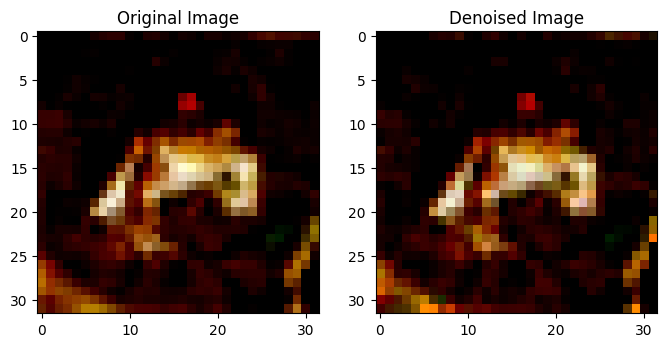

PSNR: 30.271120399630288
SSIM: 0.9335585236549377


<ipython-input-14-eb16af7407da>:144: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Step 1: Define DIP Model
class DIP(nn.Module):
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Step 2: Define DDPM Model
class DDPMBlock(nn.Module):
    def __init__(self, channels, noise_schedule):
        super(DDPMBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.sigma_schedule = nn.Parameter(torch.tensor(noise_schedule), requires_grad=False)

    def forward(self, x, t):
        sigma_t = self.sigma_schedule[t]
        noise = torch.randn_like(x) * sigma_t
        return x + noise - self.net(x)

class DDPM(nn.Module):
    def __init__(self, num_blocks, channels, noise_schedule):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList([DDPMBlock(channels, noise_schedule) for _ in range(num_blocks)])

    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x

# Step 3: Preprocess CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Exp3 here
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Step 4: Initialize DIP Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

channels = 3  # For RGB images
dip_model = DIP(channels).to(device)
dip_criterion = nn.MSELoss()
dip_optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Step 5: Pre-training DIP Model
num_dip_epochs = 20
for epoch in range(num_dip_epochs):
    dip_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        dip_optimizer.zero_grad()
        outputs = dip_model(inputs)
        loss = dip_criterion(outputs, inputs)
        loss.backward()
        dip_optimizer.step()
        running_loss += loss.item()
    print(f"DIP Epoch [{epoch+1}/{num_dip_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 6: Fine-tuning DIP Model using DDPM
num_blocks = 10
noise_schedule = [0.01 * (i / 1000) for i in range(1000)]  # Example noise schedule
ddpm_model = DDPM(num_blocks, channels, noise_schedule).to(device)
ddpm_criterion = nn.MSELoss()
ddpm_optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)

# Freeze DIP model parameters
for param in dip_model.parameters():
    param.requires_grad = False

# Step 7: Fine-tuning Loop
num_ddpm_epochs = 20
for epoch in range(num_ddpm_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(trainloader):
        inputs = inputs.to(device)
        ddpm_optimizer.zero_grad()

        # Forward pass through DIP model
        with torch.no_grad():
            dip_outputs = dip_model(inputs)

        # Forward pass through DDPM model
        ddpm_outputs = ddpm_model(dip_outputs, t=torch.randint(0, len(noise_schedule), (1,)).item())

        # Compute loss
        loss = ddpm_criterion(ddpm_outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        ddpm_optimizer.step()

        running_loss += loss.item()
    print(f"DDPM Epoch [{epoch+1}/{num_ddpm_epochs}], Loss: {running_loss/len(trainloader)}")

# Step 8: Evaluation and Sample Generation
def denoise_image(model, image, num_steps=10):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for t in range(num_steps):
            x = model(x, t=torch.randint(0, len(noise_schedule), (1,)).item())
    return x.cpu().squeeze(0)

# Choose a random image from the dataset for evaluation
test_image, _ = trainset[0]
denoised_image = denoise_image(ddpm_model, test_image)

# Plot original and denoised images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))
plt.show()

# Calculate PSNR and SSIM
psnr_value = psnr(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy())
ssim_value = ssim(torch.clone(test_image).cpu().permute(1, 2, 0).numpy(),
                  denoised_image.cpu().permute(1, 2, 0).numpy(), multichannel=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")